In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from time import time
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from google_drive_downloader import GoogleDriveDownloader as gdd

# Utility

In [2]:
def plot_image_samples(X, transform =None):
    # Transforming data in range [0, 1]
    X = X if transform is None else transform(X)

    plt.figure(figsize=(18, 6))
    for idx, x in enumerate(X[:30]):
        plt.subplot(3, 10, idx+1)
        plt.imshow(x.transpose(0, 2).transpose(0, 1))
        plt.axis("off")
    plt.show()

In [3]:
standardize = lambda x: transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))(x)

# Data Preprocessing

In [4]:
# Download Data

gdd.download_file_from_google_drive(file_id='178ggUZjW-pToCRRKFsIBVKnjVZSsYePp',
                                    dest_path='./brain-tumor-dataset.zip',
                                    unzip=True)

Unzipping...Done.


In [5]:
# Data Loader

def dataset_loader(path, batch_size=32, shuffle=True):
    train_dataset = torchvision.datasets.ImageFolder(
        root=path,
        transform = transforms.Compose([
                                          transforms.Resize((96, 96)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                      ])
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=shuffle
    )

    return train_loader

In [6]:
# Datalaoder Object

data = dataset_loader("Brain Tumor Data Set/Brain Tumor Data Set/")

In [7]:
# A Data batch

X = next(iter(data))[0]

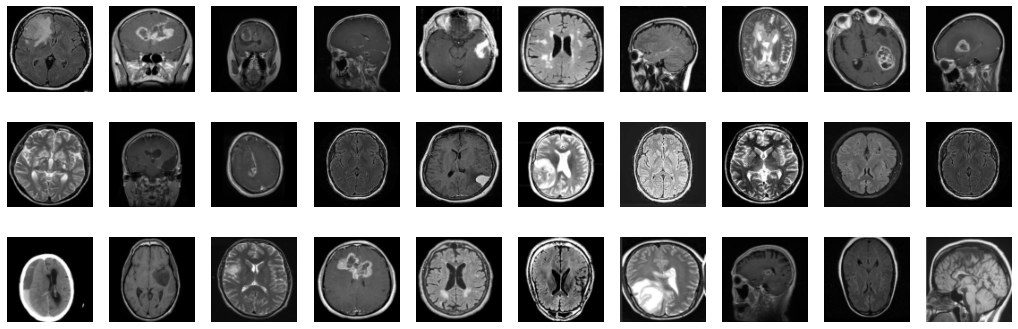

In [8]:
plot_image_samples(X, lambda x: (x+1)/2)

In [9]:
# Single Image Shape

X[0].shape

torch.Size([3, 96, 96])

# Modelling

In [10]:
# Set Device

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
# Modelling Parameters

IMAGE_SHAPE = (3, 96, 96)
LATENT_DIMS = 32

In [12]:
# Encoder Model

class Encoder(nn.Module):
    def __init__(self, latent_dims=LATENT_DIMS, input_shape=IMAGE_SHAPE, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.input_shape = input_shape
        self.latent_dims = latent_dims
        self.l1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), stride=2) 
        self.l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=2) 
        self.l3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=2) 
        self.l4 = nn.Conv1d(in_channels=128, out_channels=3, kernel_size=(1,1)) 
        self.mu = nn.Linear(in_features=363, out_features=latent_dims) 
        self.log_var = nn.Linear(in_features=363, out_features=latent_dims) # Modelling with zero covariance b/n all latent dims.
    
    def forward(self, x, f=F.relu):
        # Model defination
        x = f(self.l1(x)) # [None, 32, 47, 47]
        x = f(self.l2(x)) # [None, 64, 23, 23]
        x = f(self.l3(x)) # [None, 128, 11, 11]
        x = f(self.l4(x)) # [None, 3, 11, 11]
        x = torch.flatten(x, start_dim=1)   # [None, 3*11*11=363]
            
        # Data Distribution Parameters
        mu = self.mu(x)       # [None, latent_dims]
        log_var = self.log_var(x) # [None, latent_dims]

        return [mu, log_var]

In [13]:
# Decoder Model

class Decoder(nn.Module):
    def __init__(self, latent_dims=LATENT_DIMS, output_shape=IMAGE_SHAPE, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.output_shape = output_shape
        self.latent_dims = latent_dims
        self.l1 = nn.Linear(in_features=latent_dims, out_features=4*latent_dims)
        self.l2 = nn.Linear(in_features=4*latent_dims, out_features=8*latent_dims)
        self.l3 = nn.Linear(in_features=8*latent_dims, out_features=16*latent_dims)
        self.l4 = nn.ConvTranspose2d(in_channels=2, out_channels=output_shape[0], kernel_size=(3,3), stride=3)
        self.l5 = nn.ConvTranspose2d(in_channels=output_shape[0], out_channels=output_shape[0], kernel_size=(3,3), stride=2)
        self.l6 = nn.Conv2d(in_channels=output_shape[0], out_channels=output_shape[0], kernel_size=(2,2))
    
    def forward(self, x, f=F.relu):
        # Model defination
        x = f(self.l1(x))     # [None, latent_dim*4]
        x = f(self.l2(x))     # [None, latent_dim*8]
        x = f(self.l3(x))     # [None, latent_dim*16]
        x = torch.reshape(x, (-1, 2, self.latent_dims//2, self.latent_dims//2)) # [None, 2, 16, 16]
        x = f(self.l4(x))     # [None, 3, 48, 48]
        x = f(self.l5(x))     # [None, 3, 97, 97]
        x = torch.sigmoid(self.l6(x))     # [None, 3, 96, 96]
        return x

KL divergence of two gaussian is defined as

$$KL(p||q) = {1 \over 2}\Bigg(\log\Bigg( \frac{|\Sigma_2|}{|\Sigma_1|}\Bigg)  -n + Trace\Big(\Sigma_2^{-1}\Sigma_1 \Big) + (\mu_2 - \mu_1)^T\Sigma_2^{-1}(\mu_2 - \mu_1)\Bigg)$$

where $P \sim N(\mu_1, \Sigma_1)$ and $Q \sim N(\mu_2, \Sigma_2)$.

In our case $Q = N(\vec0, \mathbb{I})$. It reduces KL to

$$KL(p||q) = {1 \over 2}\Bigg(-\log\big( |\Sigma_1|\big)  -n + Trace\Big(\Sigma_1 \Big) + \mu_1^2\Bigg)$$

In [29]:
# VAE

class VAE(nn.Module):
    def __init__(self, latent_dims=LATENT_DIMS, image_shape=IMAGE_SHAPE, beta=10.0, **kwargs):
        super(VAE, self).__init__(**kwargs)

        self.encoder = Encoder(latent_dims, image_shape)
        self.decoder = Decoder(latent_dims, image_shape)
        self.beta = beta

        self.kl_loss = None
        self.reconstr_loss = None

    def forward(self, x):
        # Get Data Distribution's Parameters
        mu, log_var = self.encoder(x)
        
        # Reparameterization Trick
        z = mu + torch.exp(0.5*log_var)*torch.randn_like(mu) if self.training else mu

        # Reocnstruct Data points using latent space embeddings.
        reconstructed_x = self.decoder(z)

        """
        if self.training:
            # We can use any metric function here.
            #self.reconstr_loss = torch.mean(torch.square(reconstructed_x.view(-1, np.prod(INPUT_SHAPE)) - x.view(-1, np.prod(INPUT_SHAPE))), axis=-1)
            self.reconstr_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
            
            self.kl_loss = self.beta * 0.5 * torch.sum(-log_var - 1 + torch.exp(log_var) + torch.square(mu))
        """
        
        return reconstructed_x, mu, log_var


In [30]:
# Model Instantiation
model = VAE(beta=1e3)
model = model.to(device)

# Forward Propagation
X_bar, _, _ = model.forward(X.to(device))

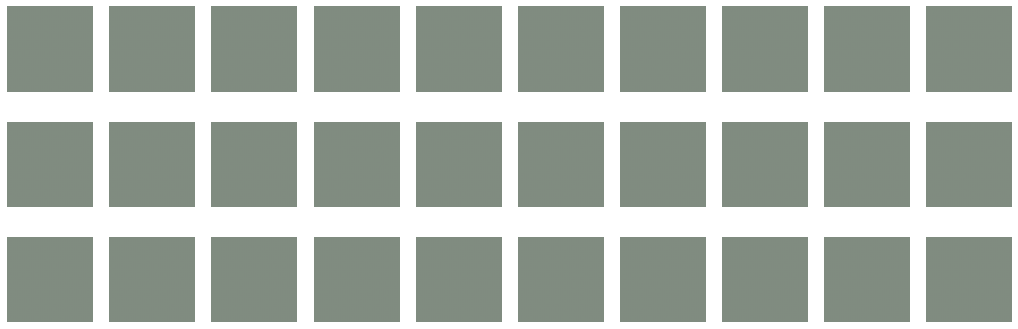

In [31]:
# Output of untrained VAE

plot_image_samples(X_bar[:].detach().cpu())

# Training Loop

In [32]:
# Traingin Params

opt = torch.optim.Adam(model.parameters())
EPOCHS = 100

history = {'recon-loss': [], 'kl-loss': []}

In [33]:
# Custom Training Loop

model.train()

round = 0
for epoch in range(EPOCHS):
    count = 0
    tick = time()
    l1, l2 = 0, 0

    for idx, X in enumerate(data):
        count += 1

        # Copy data to Device
        X = X[0].to(device)

        # Forward Pass
        reconstructed_x, mu, log_var = model.forward(X)
        
        # Loss Calculation
        rec_loss = F.binary_cross_entropy(reconstructed_x, X, reduction='sum')
        kl_loss = 100 * 0.5 * torch.sum(-log_var - 1 + torch.exp(log_var) + torch.square(mu))
        loss = rec_loss + kl_loss
        
        # Backpropagation
        opt.zero_grad()
        loss.backward()
        
        # Apply Jacobians to Weights
        opt.step()

        l1 += rec_loss.item()
        l2 += kl_loss.item()
        
    # Log Training
    history["recon-loss"].append(l1/count)
    history["kl-loss"].append(l2/count)
    
    # Training Moniotring
    tock = time()
    round += 1
    print(f"""Epoch [{round} / {EPOCHS}] 
    - KL-Loss: {history["kl-loss"][-1]: 0.6f} 
    - Recon-Loss: {history["recon-loss"][-1]: 0.6f} 
    - Total-Loss: {(history["kl-loss"][-1] + history["recon-loss"][-1]): 0.6f}
    - Time-Taken: {(tock-tick): 0.6f} sec""", end="\n\n")

Epoch [1 / 100] 
    - KL-Loss:  281877.810970 
    - Recon-Loss: -14826366.026238 
    - Total-Loss: -14544488.215269
    - Time-Taken:  16.313145 sec

Epoch [2 / 100] 
    - KL-Loss:  48014.386882 
    - Recon-Loss: -29490010.513889 
    - Total-Loss: -29441996.127007
    - Time-Taken:  16.353883 sec



KeyboardInterrupt: ignored